In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset
train_dataset = datasets.ImageFolder(root='/Users/ayush/Desktop/Projects/facial-Emo-Reco/dataset/1/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Inspect dataset
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")
print(f"Number of samples: {len(train_dataset)}")

Number of classes: 7
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of samples: 28709


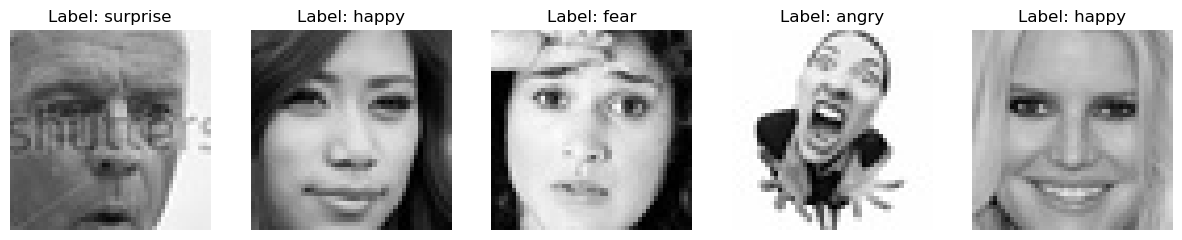

In [3]:
import matplotlib.pyplot as plt

# Get a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0).squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {train_dataset.classes[labels[i]]}")
    axes[i].axis('off')
plt.show()

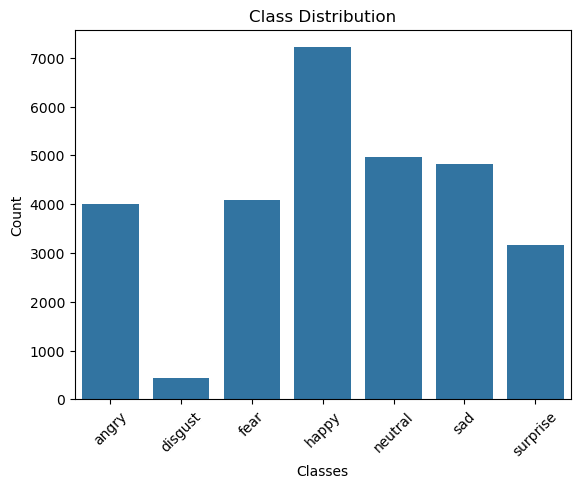

In [4]:
import seaborn as sns
import pandas as pd

# Get class counts
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1

# Plot class distribution
sns.barplot(x=train_dataset.classes, y=class_counts)
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [5]:
# Calculate mean and std
all_images = torch.cat([images for images, _ in train_loader], dim=0)
mean = all_images.mean()
std = all_images.std()

print(f"Mean: {mean.item()}, Std: {std.item()}")

# Inspect pixel value range
print(f"Min pixel value: {all_images.min().item()}, Max pixel value: {all_images.max().item()}")

Mean: 0.5077385902404785, Std: 0.2550775706768036
Min pixel value: 0.0, Max pixel value: 1.0


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, num_classes)  # Fully connected layer 2 (output)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 32 * 64 * 64)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer 1 -> ReLU
        x = self.fc2(x)  # Fully connected layer 2 (output)
        return x

# Instantiate the model
num_classes = len(train_dataset.classes)  # Number of emotion classes
model = SimpleCNN(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [9]:
pip show torch

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /Users/ayush/miniconda3/envs/cv/lib/python3.10/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set the device to MPS if available, otherwise fallback to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor()
])

# Load dataset
train_dataset = datasets.ImageFolder(root='/Users/ayush/Desktop/Projects/facial-Emo-Reco/dataset/1/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling

        # Dynamically calculate the flattened size
        dummy_input = torch.randn(1, 3, 128, 128)  # Assuming input images are 128x128
        dummy_output = self._forward_conv(dummy_input)
        self.flattened_size = dummy_output.view(-1).size(0)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, num_classes)  # Fully connected layer 2 (output)

    def _forward_conv(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor dynamically
        x = F.relu(self.fc1(x))  # Fully connected layer 1 -> ReLU
        x = self.fc2(x)  # Fully connected layer 2 (output)
        return x

# Instantiate the model
num_classes = len(train_dataset.classes)  # Number of emotion classes
model = SimpleCNN(num_classes=num_classes).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader for simplicity; replace with test_loader for actual testing
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Using device: mps
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)
Epoch 1/10, Loss: 1.656749806186404
Epoch 2/10, Loss: 1.4375161568412271
Epoch 3/10, Loss: 1.2649006560809894
Epoch 4/10, Loss: 1.0997830703024876
Epoch 5/10, Loss: 0.9278905375099394
Epoch 6/10, Loss: 0.7277750696464211
Epoch 7/10, Loss: 0.5304689754323333
Epoch 8/10, Loss: 0.3690772122373692
Epoch 9/10, Loss: 0.24416214107371917
Epoch 10/10, Loss: 0.16407276711681804
Accuracy: 96.30%
